# Meiling Han's Words from Heaven

In [1]:
# https://www.kaggle.com/artgor/dcgan-baseline
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [2]:
len(os.listdir('../input/daqian-oracle'))

2

In [3]:
# Setting parameters
dataroot = "../input"
workers = 2

batch_size = 128
image_size = 64

# Number of channels
nc = 3
# Latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
epochs = 1000
# Learning rate for optimizers
lr_gen = 0.001
lr_dis = 0.00001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.3
ngpu = 1

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((image_size+30, image_size+30)),
                               transforms.RandomCrop((image_size, image_size), padding=None, pad_if_needed=False, fill=1, padding_mode='constant'),
                               transforms.RandomHorizontalFlip(p=0.5), # could be improved
                               transforms.RandomVerticalFlip(p=0.5),
#                                transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
#                                transforms.RandomRotation((-20, +20), resample=False, expand=False, center=None, fill=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

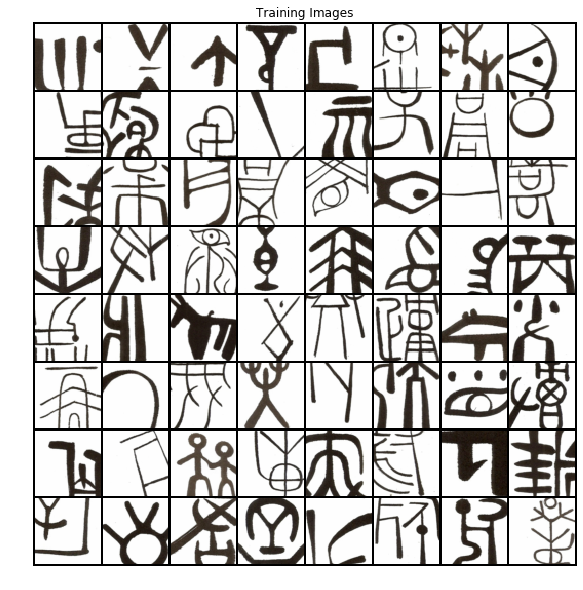

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images");
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [6]:
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [7]:
# https://www.kaggle.com/phoenix9032/gan-dogs-starter-24-jul-custom-layers
def show_generated_img_all():
    gen_z = torch.randn(32, nz, 1, 1, device=device)
    gen_images = netG(gen_z).to("cpu").clone().detach()
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)
    #plt.savefig(filename)  
    
### This is to show one sample image for iteration of chosing
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

class MinibatchStdDev(torch.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)
        # return the computed values:
        return y

In [8]:
from torch.nn.utils import spectral_norm
from torch.optim import lr_scheduler

class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()
    def forward(self, x):
        #x = F.leaky_relu(self.bn1(self.conv1(x)))
        #x = F.leaky_relu(self.bn2(self.conv2(x)))
        #x = F.leaky_relu(self.bn3(self.conv3(x)))
        #x = F.leaky_relu(self.bn4(self.conv4(x)))
        #x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        self.pixnorm = PixelwiseNorm()
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
       # x = self.pixnorm(x)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        #x= self.conv5(x)
        return x.view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0002
lr_d = 0.0002
beta1 = 0.5
epochs = 1600
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()
#criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, 0.999))
# lr_schedulerG = lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//200, eta_min=0.00005)
# lr_schedulerD = lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//200, eta_min=0.00005)
lr_schedulerG = lr_scheduler.MultiStepLR(optimizerG, milestones=[150, 200], gamma=0.1)
lr_schedulerD = lr_scheduler.MultiStepLR(optimizerD, milestones=[150, 200], gamma=0.1)

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.7
fake_label = 0.0

[1/1600][0/8] Loss_D: 1.3745 Loss_G: 1.1584 D(x): 0.2953 D(G(z)): 0.3451 / 0.2136
[1/1600][2/8] Loss_D: 1.3876 Loss_G: 1.5426 D(x): 0.4108 D(G(z)): 0.4630 / 0.1174
[1/1600][4/8] Loss_D: 1.3883 Loss_G: 1.6096 D(x): 0.3125 D(G(z)): 0.3534 / 0.1058
[1/1600][6/8] Loss_D: 1.4643 Loss_G: 1.7134 D(x): 0.3552 D(G(z)): 0.4244 / 0.0907


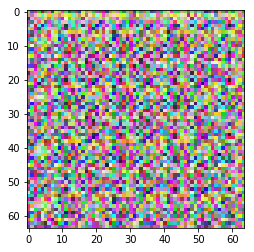

[2/1600][0/8] Loss_D: 1.2696 Loss_G: 1.9354 D(x): 0.3918 D(G(z)): 0.3740 / 0.0651
[2/1600][2/8] Loss_D: 1.0612 Loss_G: 2.3136 D(x): 0.4585 D(G(z)): 0.2656 / 0.0375
[2/1600][4/8] Loss_D: 1.1479 Loss_G: 2.9112 D(x): 0.4905 D(G(z)): 0.3480 / 0.0158
[2/1600][6/8] Loss_D: 1.0354 Loss_G: 3.0998 D(x): 0.4180 D(G(z)): 0.2064 / 0.0120
[3/1600][0/8] Loss_D: 1.1398 Loss_G: 3.2646 D(x): 0.5395 D(G(z)): 0.3483 / 0.0095
[3/1600][2/8] Loss_D: 1.0883 Loss_G: 3.0464 D(x): 0.5141 D(G(z)): 0.3096 / 0.0130
[3/1600][4/8] Loss_D: 0.9389 Loss_G: 3.2485 D(x): 0.5384 D(G(z)): 0.1984 / 0.0097
[3/1600][6/8] Loss_D: 0.9550 Loss_G: 3.3348 D(x): 0.4527 D(G(z)): 0.1744 / 0.0086
[4/1600][0/8] Loss_D: 0.8545 Loss_G: 3.3595 D(x): 0.5203 D(G(z)): 0.1272 / 0.0083
[4/1600][2/8] Loss_D: 0.7871 Loss_G: 3.4227 D(x): 0.6409 D(G(z)): 0.1559 / 0.0076
[4/1600][4/8] Loss_D: 0.8161 Loss_G: 3.5808 D(x): 0.6380 D(G(z)): 0.0974 / 0.0060
[4/1600][6/8] Loss_D: 0.8480 Loss_G: 3.0416 D(x): 0.4866 D(G(z)): 0.0957 / 0.0131
[5/1600][0/8] Lo

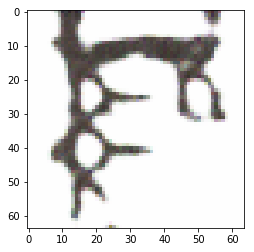

[202/1600][0/8] Loss_D: 0.7692 Loss_G: 2.0235 D(x): 0.6403 D(G(z)): 0.0640 / 0.0630
[202/1600][2/8] Loss_D: 0.7514 Loss_G: 2.0164 D(x): 0.5720 D(G(z)): 0.0619 / 0.0625
[202/1600][4/8] Loss_D: 0.7728 Loss_G: 1.9768 D(x): 0.6116 D(G(z)): 0.0677 / 0.0671
[202/1600][6/8] Loss_D: 0.7712 Loss_G: 2.0782 D(x): 0.5799 D(G(z)): 0.0576 / 0.0571
[203/1600][0/8] Loss_D: 0.7589 Loss_G: 2.0526 D(x): 0.5770 D(G(z)): 0.0603 / 0.0602
[203/1600][2/8] Loss_D: 0.7661 Loss_G: 2.0103 D(x): 0.6111 D(G(z)): 0.0643 / 0.0640
[203/1600][4/8] Loss_D: 0.7384 Loss_G: 2.0374 D(x): 0.6304 D(G(z)): 0.0618 / 0.0617
[203/1600][6/8] Loss_D: 0.7149 Loss_G: 2.0270 D(x): 0.6104 D(G(z)): 0.0609 / 0.0615
[204/1600][0/8] Loss_D: 0.6816 Loss_G: 2.1033 D(x): 0.6221 D(G(z)): 0.0546 / 0.0553
[204/1600][2/8] Loss_D: 0.7334 Loss_G: 1.9749 D(x): 0.6177 D(G(z)): 0.0672 / 0.0677
[204/1600][4/8] Loss_D: 0.7096 Loss_G: 1.9489 D(x): 0.6303 D(G(z)): 0.0695 / 0.0697
[204/1600][6/8] Loss_D: 0.7646 Loss_G: 1.9477 D(x): 0.6111 D(G(z)): 0.0709 /

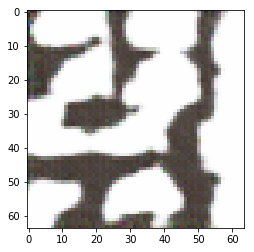

[402/1600][0/8] Loss_D: 0.7228 Loss_G: 2.0610 D(x): 0.6388 D(G(z)): 0.0595 / 0.0582
[402/1600][2/8] Loss_D: 0.6430 Loss_G: 2.0225 D(x): 0.6558 D(G(z)): 0.0612 / 0.0624
[402/1600][4/8] Loss_D: 0.7276 Loss_G: 2.0527 D(x): 0.6216 D(G(z)): 0.0599 / 0.0596
[402/1600][6/8] Loss_D: 0.7496 Loss_G: 2.0069 D(x): 0.6197 D(G(z)): 0.0627 / 0.0627
[403/1600][0/8] Loss_D: 0.6827 Loss_G: 1.9827 D(x): 0.6292 D(G(z)): 0.0639 / 0.0656
[403/1600][2/8] Loss_D: 0.7280 Loss_G: 1.9405 D(x): 0.6229 D(G(z)): 0.0697 / 0.0704
[403/1600][4/8] Loss_D: 0.7520 Loss_G: 1.9793 D(x): 0.6520 D(G(z)): 0.0673 / 0.0653
[403/1600][6/8] Loss_D: 0.7220 Loss_G: 2.0078 D(x): 0.6119 D(G(z)): 0.0621 / 0.0621
[404/1600][0/8] Loss_D: 0.7700 Loss_G: 2.0361 D(x): 0.6554 D(G(z)): 0.0612 / 0.0598
[404/1600][2/8] Loss_D: 0.7447 Loss_G: 1.9136 D(x): 0.6204 D(G(z)): 0.0724 / 0.0723
[404/1600][4/8] Loss_D: 0.7235 Loss_G: 1.9369 D(x): 0.6053 D(G(z)): 0.0691 / 0.0702
[404/1600][6/8] Loss_D: 0.7572 Loss_G: 1.9415 D(x): 0.6615 D(G(z)): 0.0721 /

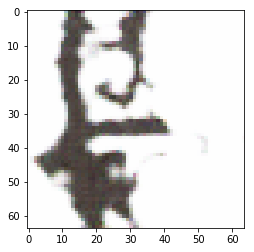

[602/1600][0/8] Loss_D: 0.7314 Loss_G: 1.7729 D(x): 0.6242 D(G(z)): 0.0871 / 0.0893
[602/1600][2/8] Loss_D: 0.7724 Loss_G: 1.7005 D(x): 0.6388 D(G(z)): 0.0995 / 0.0981
[602/1600][4/8] Loss_D: 0.7715 Loss_G: 1.7649 D(x): 0.6507 D(G(z)): 0.0930 / 0.0896
[602/1600][6/8] Loss_D: 0.8178 Loss_G: 1.7516 D(x): 0.6327 D(G(z)): 0.0951 / 0.0908
[603/1600][0/8] Loss_D: 0.7973 Loss_G: 1.8584 D(x): 0.5958 D(G(z)): 0.0831 / 0.0795
[603/1600][2/8] Loss_D: 0.7080 Loss_G: 1.8648 D(x): 0.6033 D(G(z)): 0.0756 / 0.0772
[603/1600][4/8] Loss_D: 0.7488 Loss_G: 1.8462 D(x): 0.6344 D(G(z)): 0.0783 / 0.0789
[603/1600][6/8] Loss_D: 0.7708 Loss_G: 1.8218 D(x): 0.6450 D(G(z)): 0.0855 / 0.0836
[604/1600][0/8] Loss_D: 0.7423 Loss_G: 1.7815 D(x): 0.6234 D(G(z)): 0.0884 / 0.0883
[604/1600][2/8] Loss_D: 0.7902 Loss_G: 1.8174 D(x): 0.5775 D(G(z)): 0.0838 / 0.0828
[604/1600][4/8] Loss_D: 0.7156 Loss_G: 1.8188 D(x): 0.6036 D(G(z)): 0.0812 / 0.0834
[604/1600][6/8] Loss_D: 0.7473 Loss_G: 1.8364 D(x): 0.6102 D(G(z)): 0.0794 /

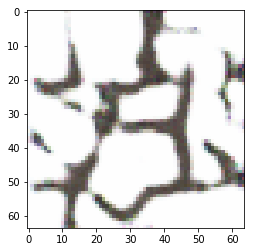

[802/1600][0/8] Loss_D: 0.7158 Loss_G: 1.9287 D(x): 0.5933 D(G(z)): 0.0699 / 0.0707
[802/1600][2/8] Loss_D: 0.7675 Loss_G: 1.9579 D(x): 0.5870 D(G(z)): 0.0685 / 0.0678
[802/1600][4/8] Loss_D: 0.6857 Loss_G: 1.9439 D(x): 0.6141 D(G(z)): 0.0696 / 0.0702
[802/1600][6/8] Loss_D: 0.7563 Loss_G: 1.8859 D(x): 0.5999 D(G(z)): 0.0768 / 0.0772
[803/1600][0/8] Loss_D: 0.7607 Loss_G: 1.8907 D(x): 0.5738 D(G(z)): 0.0732 / 0.0738
[803/1600][2/8] Loss_D: 0.7035 Loss_G: 1.8550 D(x): 0.6036 D(G(z)): 0.0781 / 0.0807
[803/1600][4/8] Loss_D: 0.7296 Loss_G: 1.8446 D(x): 0.5781 D(G(z)): 0.0778 / 0.0801
[803/1600][6/8] Loss_D: 0.7441 Loss_G: 1.8072 D(x): 0.6743 D(G(z)): 0.0862 / 0.0838
[804/1600][0/8] Loss_D: 0.7813 Loss_G: 1.8834 D(x): 0.6458 D(G(z)): 0.0790 / 0.0758
[804/1600][2/8] Loss_D: 0.6907 Loss_G: 1.9192 D(x): 0.6161 D(G(z)): 0.0722 / 0.0726
[804/1600][4/8] Loss_D: 0.7069 Loss_G: 1.9070 D(x): 0.6064 D(G(z)): 0.0706 / 0.0724
[804/1600][6/8] Loss_D: 0.7550 Loss_G: 1.8590 D(x): 0.6394 D(G(z)): 0.0800 /

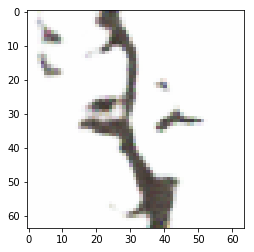

[1002/1600][0/8] Loss_D: 0.7090 Loss_G: 1.8794 D(x): 0.5956 D(G(z)): 0.0751 / 0.0765
[1002/1600][2/8] Loss_D: 0.7528 Loss_G: 1.7845 D(x): 0.6273 D(G(z)): 0.0884 / 0.0897
[1002/1600][4/8] Loss_D: 0.7033 Loss_G: 1.8700 D(x): 0.6340 D(G(z)): 0.0790 / 0.0785
[1002/1600][6/8] Loss_D: 0.7722 Loss_G: 1.8202 D(x): 0.6475 D(G(z)): 0.0857 / 0.0841
[1003/1600][0/8] Loss_D: 0.7100 Loss_G: 1.8732 D(x): 0.5989 D(G(z)): 0.0749 / 0.0771
[1003/1600][2/8] Loss_D: 0.7495 Loss_G: 1.8269 D(x): 0.6490 D(G(z)): 0.0845 / 0.0834
[1003/1600][4/8] Loss_D: 0.7827 Loss_G: 1.8774 D(x): 0.6626 D(G(z)): 0.0811 / 0.0767
[1003/1600][6/8] Loss_D: 0.7630 Loss_G: 1.9033 D(x): 0.5860 D(G(z)): 0.0748 / 0.0730
[1004/1600][0/8] Loss_D: 0.7183 Loss_G: 1.9761 D(x): 0.6552 D(G(z)): 0.0665 / 0.0668
[1004/1600][2/8] Loss_D: 0.7321 Loss_G: 1.8667 D(x): 0.5895 D(G(z)): 0.0748 / 0.0770
[1004/1600][4/8] Loss_D: 0.7627 Loss_G: 1.7918 D(x): 0.6413 D(G(z)): 0.0890 / 0.0888
[1004/1600][6/8] Loss_D: 0.7641 Loss_G: 1.8317 D(x): 0.6026 D(G(z

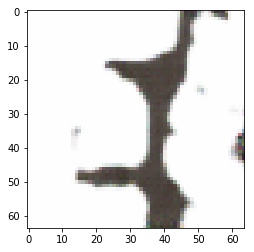

[1202/1600][0/8] Loss_D: 0.7113 Loss_G: 1.8066 D(x): 0.6194 D(G(z)): 0.0847 / 0.0860
[1202/1600][2/8] Loss_D: 0.7730 Loss_G: 1.9024 D(x): 0.5643 D(G(z)): 0.0739 / 0.0742
[1202/1600][4/8] Loss_D: 0.7595 Loss_G: 1.8596 D(x): 0.6667 D(G(z)): 0.0817 / 0.0795
[1202/1600][6/8] Loss_D: 0.7894 Loss_G: 1.8148 D(x): 0.5860 D(G(z)): 0.0847 / 0.0828
[1203/1600][0/8] Loss_D: 0.7589 Loss_G: 1.9076 D(x): 0.5869 D(G(z)): 0.0737 / 0.0734
[1203/1600][2/8] Loss_D: 0.7279 Loss_G: 1.8755 D(x): 0.6325 D(G(z)): 0.0778 / 0.0781
[1203/1600][4/8] Loss_D: 0.7111 Loss_G: 1.7903 D(x): 0.6442 D(G(z)): 0.0867 / 0.0873
[1203/1600][6/8] Loss_D: 0.6824 Loss_G: 1.7407 D(x): 0.6493 D(G(z)): 0.0930 / 0.0954
[1204/1600][0/8] Loss_D: 0.6764 Loss_G: 1.7446 D(x): 0.6719 D(G(z)): 0.0923 / 0.0940
[1204/1600][2/8] Loss_D: 0.7789 Loss_G: 1.7278 D(x): 0.6121 D(G(z)): 0.0967 / 0.0956
[1204/1600][4/8] Loss_D: 0.7179 Loss_G: 1.8286 D(x): 0.6131 D(G(z)): 0.0818 / 0.0809
[1204/1600][6/8] Loss_D: 0.7586 Loss_G: 1.8327 D(x): 0.5890 D(G(z

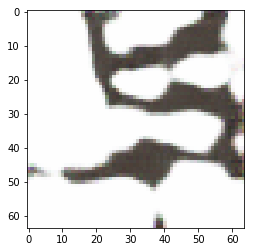

[1402/1600][0/8] Loss_D: 0.7566 Loss_G: 1.7078 D(x): 0.5541 D(G(z)): 0.0930 / 0.1009
[1402/1600][2/8] Loss_D: 0.8256 Loss_G: 1.7388 D(x): 0.6746 D(G(z)): 0.0998 / 0.0944
[1402/1600][4/8] Loss_D: 0.8022 Loss_G: 1.7574 D(x): 0.5999 D(G(z)): 0.0978 / 0.0928
[1402/1600][6/8] Loss_D: 0.7593 Loss_G: 1.8498 D(x): 0.5951 D(G(z)): 0.0846 / 0.0839
[1403/1600][0/8] Loss_D: 0.8057 Loss_G: 1.7795 D(x): 0.6129 D(G(z)): 0.0957 / 0.0902
[1403/1600][2/8] Loss_D: 0.7595 Loss_G: 1.8381 D(x): 0.5630 D(G(z)): 0.0827 / 0.0837
[1403/1600][4/8] Loss_D: 0.7091 Loss_G: 1.9576 D(x): 0.6353 D(G(z)): 0.0690 / 0.0695
[1403/1600][6/8] Loss_D: 0.6953 Loss_G: 1.8517 D(x): 0.6175 D(G(z)): 0.0799 / 0.0817
[1404/1600][0/8] Loss_D: 0.7009 Loss_G: 1.8566 D(x): 0.6061 D(G(z)): 0.0768 / 0.0793
[1404/1600][2/8] Loss_D: 0.7709 Loss_G: 1.8033 D(x): 0.5848 D(G(z)): 0.0855 / 0.0859
[1404/1600][4/8] Loss_D: 0.7759 Loss_G: 1.8486 D(x): 0.5926 D(G(z)): 0.0808 / 0.0808
[1404/1600][6/8] Loss_D: 0.7419 Loss_G: 1.8299 D(x): 0.6075 D(G(z

In [9]:
from tqdm import tqdm_notebook as tqdm
from time import time
import torch.nn.functional as F
from scipy.stats import truncnorm
start = time()

G_losses = []
D_losses = []

real_chance = []
fake_chance = []

step = 0
for epoch in range(epochs):
    for ii, (real_images) in enumerate(dataloader):
        end = time()
        if (end -start) > 25000 :
            break
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        real_images = real_images[0] ############################################ CAREFUL
        
        
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(-0.1, 0.1)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label) + np.random.uniform(0, 0.2)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        real_chance.append(errD_real.item())
        fake_chance.append(errD_fake.item())
        
        if step % 2 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)

    if epoch % 200 == 0:
        show_generated_img()

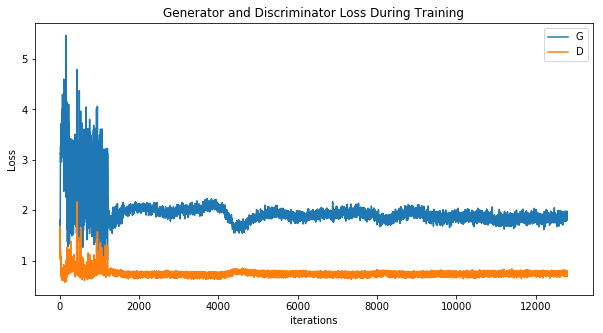

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

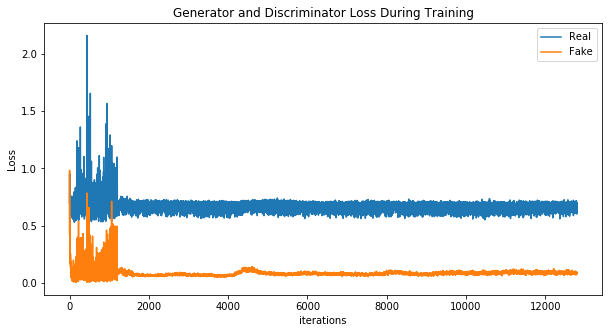

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(real_chance,label="Real")
plt.plot(fake_chance,label="Fake")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 100
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, 100, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    #gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)): save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

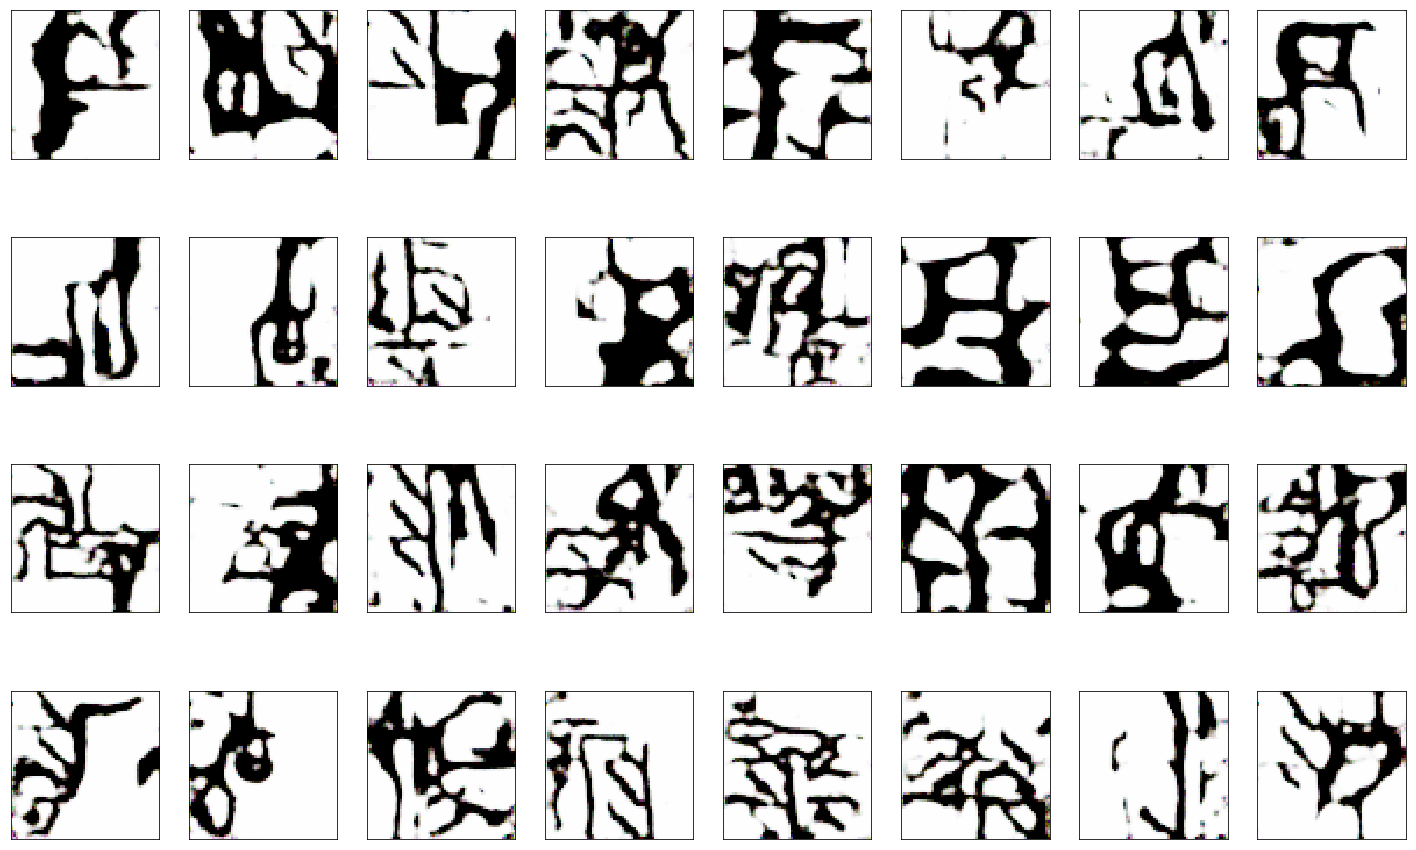

In [13]:
# https://www.kaggle.com/artgor/dcgan-baseline
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)